In [28]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/기계학습/팀프로젝트

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/기계학습/팀프로젝트'
/content/drive/MyDrive/기계학습/팀프로젝트


In [29]:
import pandas as pd

player_stat_data = pd.read_csv('final_nba_data_2.csv')
player_stat_data.head()

,name,start,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,target,Pos,G,Pos_PG,Pos_SG,Pos_SF,Pos_PF,Pos_C,contract_period,Annual
0,A.J. Lawson,2023,0.000000,7.290196,1.407843,2.917647,0.484275,0.521569,1.488235,0.334510,...,0.013971,SG,59.647059,False,True,False,False,False,4,3
1,Aaron Brooks,2012,9.076271,21.790678,3.694068,9.929661,0.378297,1.194068,4.012712,0.299822,...,0.057252,PG,118.000000,True,False,False,False,False,2,6
2,Aaron Brooks,2013,18.679245,18.783019,2.691509,5.989623,0.446028,0.903774,2.531132,0.369425,...,0.016154,PG,106.000000,True,False,False,False,False,1,7
3,Aaron Brooks,2014,12.768000,20.421200,2.986000,7.197600,0.419640,1.143600,3.049600,0.380432,...,0.018167,PG,127.888000,True,False,False,False,False,1,8
4,Aaron Brooks,2015,12.982301,22.125221,3.564602,8.780973,0.407757,1.385398,3.565044,0.387978,...,0.032143,PG,121.504425,True,False,False,False,False,1,9


In [30]:
from sklearn.svm import SVR
import joblib

best_model = joblib.load('./best_svr.pkl')

In [31]:
from sklearn.preprocessing import StandardScaler

#데이터 전처리
player_stat_data = player_stat_data.drop(columns=['name','debut','start','end','salary','birth'])

player_stat_data['Pos'] = player_stat_data['Pos'].str.split('-').str[0]
player_stat_data = pd.get_dummies(player_stat_data, columns=['Pos'])

#정규화
scaler = StandardScaler()
player_stat_data['target'] = scaler.fit_transform(player_stat_data[['target']])

player_stat_data.head()

,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,Pos_SF,Pos_PF,Pos_C,contract_period,Annual,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,0.000000,7.290196,1.407843,2.917647,0.484275,0.521569,1.488235,0.334510,0.886275,1.458824,...,False,False,False,4,3,False,False,False,False,True
1,9.076271,21.790678,3.694068,9.929661,0.378297,1.194068,4.012712,0.299822,2.521186,5.916949,...,False,False,False,2,6,False,False,True,False,False
2,18.679245,18.783019,2.691509,5.989623,0.446028,0.903774,2.531132,0.369425,1.787736,3.408491,...,False,False,False,1,7,False,False,True,False,False
3,12.768000,20.421200,2.986000,7.197600,0.419640,1.143600,3.049600,0.380432,1.859600,4.098000,...,False,False,False,1,8,False,False,True,False,False
4,12.982301,22.125221,3.564602,8.780973,0.407757,1.385398,3.565044,0.387978,2.198230,5.147788,...,False,False,False,1,9,False,False,True,False,False


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

train_X, test_X, train_y, test_y = train_test_split(player_stat_data.drop(columns=['target']), player_stat_data['target'], test_size=0.3)

best_model.fit(train_X, train_y)
prediction = best_model.predict(test_X)
model_r2_score = r2_score(test_y, prediction)
print(model_r2_score)


0.7684040944065402


<ipython-input-33-50c2d49b69f4>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations, y=best_feature, palette='viridis')


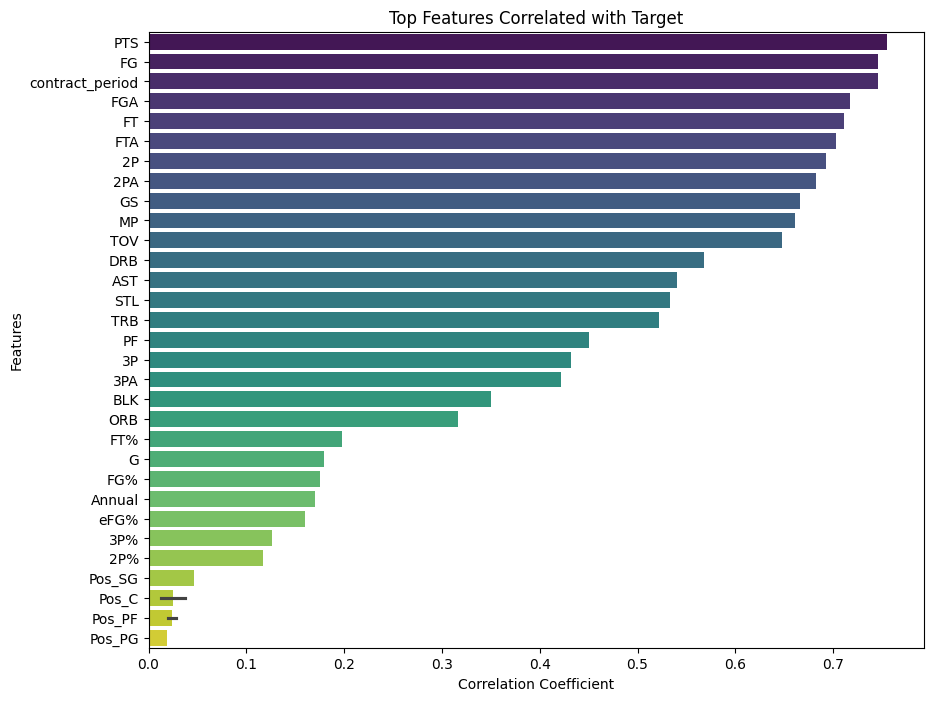

Top 33 Features R2 Score: 0.82119407810742


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


correlation_matrix = player_stat_data.corr()
target_correlations = correlation_matrix['target'].drop('target')
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

best_r2_score = 0
best_N = 0
best_feature = None
target_length = len(target_correlations.tolist()) + 1
for N in range(1, target_length):
    top_N_features = sorted_correlations.head(N).index

    top_N_feature_data = player_stat_data[top_N_features]
    train_X, test_X, train_y, test_y = train_test_split(top_N_feature_data, player_stat_data['target'], test_size=0.1, random_state=42)

    best_model.fit(train_X, train_y)
    test_predictions = best_model.predict(test_X)

    r2 = r2_score(test_y, test_predictions)
    if r2 > best_r2_score:
        best_r2_score = r2
        best_N = N
        best_feature = top_N_features

# best_feature에 해당하는 상위 N개의 상관계수 값을 가져옵니다.
top_correlations = sorted_correlations.head(best_N).tolist()

plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations, y=best_feature, palette='viridis')
plt.title('Top Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print(f"Top {best_N} Features R2 Score: {best_r2_score}")